In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable

import matplotlib.pyplot as plt

In [2]:
batch_size = 128
# batch_size = 256 #too high
# batch_size = 64 too low

# latent_size = 20
latent_size = 2

epochs = 50
# learning_rate = 0.00001
# learning_rate = 0.0001 #picks up 9s and 1s
learning_rate = 0.001
# learning_rate = 0.01 #okay - picks up 0s and 9s only
# learning_rate = 0.1 is extremely bad dont do this

In [3]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='./', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [4]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [5]:
batch_idx, example_data.shape, example_targets.shape

(0, torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [6]:
example_data.view(-1, 28*28).shape

torch.Size([128, 784])

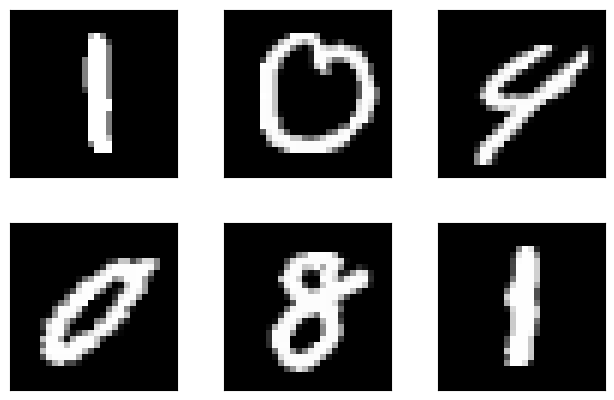

In [7]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2, 3, i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.xticks([])
  plt.yticks([])

In [8]:
example_targets[:6]

tensor([1, 0, 4, 0, 8, 1])

In [9]:
t = example_targets[:40]

In [10]:
t.shape

torch.Size([40])

In [11]:
t[:latent_size].shape, t[latent_size:].shape

(torch.Size([2]), torch.Size([38]))

In [12]:
class VAE(nn.Module):

  def __init__(self):
    super(VAE, self).__init__()
    self.encoder = nn.Sequential(
        nn.Linear(784, 256), #input layer
        nn.ReLU(),
        nn.Linear(256, 128), #hidden layer 1
        nn.ReLU(),
        nn.Linear(128, 64), #hidden layer 2
        nn.ReLU(),
        nn.Linear(64, latent_size*2) #output layer
    )
    self.decoder = nn.Sequential(
        nn.Linear(latent_size, 64),
        nn.ReLU(),
        nn.Linear(64, 128),
        nn.ReLU(),
        nn.Linear(128, 256),
        nn.ReLU(),
        nn.Linear(256, 784),
        nn.Sigmoid()
    )

  """
      # maybe change the size of pixels? from 256 to 576
    # nn.Linear(784, 256), first layer
    # nn.Linear(256, 128), second layer
            # nn.Linear(784, 576),
        # nn.ReLU(),
        # # nn.Linear(256, 128),
        # nn.Linear(576, 128),
        # nn.ReLU(),
        # nn.Linear(128, latent_size*2)


        # nn.Linear(latent_size, 128),
        # nn.ReLU(),
        # nn.Linear(128, 256),
        # nn.ReLU(),
        # nn.Linear(256, 784),
        # nn.Sigmoid()

  """

  def reparameterize(self, mu, log_var):
    std = torch.exp(0.5*log_var)
    epsilon = torch.randn_like(std)
    return mu + epsilon * std


  def forward(self, x):
    h = self.encoder(x.view(-1, 28*28))
    mu, log_var = h[:, :latent_size], h[:, latent_size:]
    z = self.reparameterize(mu, log_var)
    decoded = self.decoder(z)
    return decoded, mu, log_var

In [13]:
def loss_function(recon_x, x, mu, log_var):
  BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
  #reconstruction
  KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

  return 0.7*BCE + 0.3*KLD
  #reconstruction loss function BCE had high values for loss so need to change constant

In [14]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")

In [15]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [16]:
def train(epoch):
  model.train()
  train_loss = 0

  for batch_idx, (data,_) in enumerate(train_loader):
    data = data.to(device)
    optimizer.zero_grad()
    recon_batch, mu, log_var = model(data)
    loss = loss_function(recon_batch, data, mu, log_var)
    loss.backward()
    train_loss += loss.item()
    optimizer.step()
  print('Epoch: {} Loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

  return train_loss / len(train_loader.dataset)


In [17]:
loss_list = []

for epoch in range(1, epochs + 1):
  loss_list.append(train(epoch))

Epoch: 1 Loss: 137.4366
Epoch: 2 Loss: 113.3229
Epoch: 3 Loss: 107.9811
Epoch: 4 Loss: 105.1777
Epoch: 5 Loss: 103.1329
Epoch: 6 Loss: 101.6875
Epoch: 7 Loss: 100.4640
Epoch: 8 Loss: 99.6493
Epoch: 9 Loss: 98.8036
Epoch: 10 Loss: 98.4020
Epoch: 11 Loss: 97.8751
Epoch: 12 Loss: 97.5358
Epoch: 13 Loss: 96.9805
Epoch: 14 Loss: 96.7197
Epoch: 15 Loss: 96.4459
Epoch: 16 Loss: 96.3337
Epoch: 17 Loss: 95.7960
Epoch: 18 Loss: 96.1043
Epoch: 19 Loss: 95.6214
Epoch: 20 Loss: 95.1009
Epoch: 21 Loss: 94.8077
Epoch: 22 Loss: 94.9189
Epoch: 23 Loss: 94.9166
Epoch: 24 Loss: 95.1449
Epoch: 25 Loss: 94.5278
Epoch: 26 Loss: 94.6904
Epoch: 27 Loss: 94.2138
Epoch: 28 Loss: 94.0392
Epoch: 29 Loss: 94.2116
Epoch: 30 Loss: 94.0179
Epoch: 31 Loss: 93.6147
Epoch: 32 Loss: 93.9841
Epoch: 33 Loss: 93.6150
Epoch: 34 Loss: 94.2287
Epoch: 35 Loss: 94.0694
Epoch: 36 Loss: 93.4911
Epoch: 37 Loss: 93.7458
Epoch: 38 Loss: 93.3779
Epoch: 39 Loss: 93.5256
Epoch: 40 Loss: 93.1877
Epoch: 41 Loss: 93.3008
Epoch: 42 Loss: 93

In [33]:
# calculate code vectors
import numpy as np

model.eval()
code_vectors = []
all_labels = []
with torch.no_grad():
  for data, labels in train_loader:
    data = data.to(device)
    h = model.encoder(data.view(-1, 28*28))
    mu, log_var = h[:, :latent_size], h[:, latent_size:]
    code_vectors.append(mu.cpu().numpy())
    all_labels.append(labels.numpy())
code_vectors = np.concatenate(code_vectors)
all_labels = np.concatenate(all_labels)
print(f"code vectors: \n {code_vectors} \n")
print(f"all labels:  \n {all_labels}")

code vectors: 
 [[ 0.7686081   0.17417434]
 [ 1.0204096  -0.5407994 ]
 [ 1.0648007   0.8534051 ]
 ...
 [ 0.1730903  -0.19300134]
 [ 1.1017407  -0.6294553 ]
 [ 1.4994905   0.04417291]] 

all labels:  
 [7 8 9 ... 8 8 6]


<ipython-input-34-3d8451dde5c4>:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))


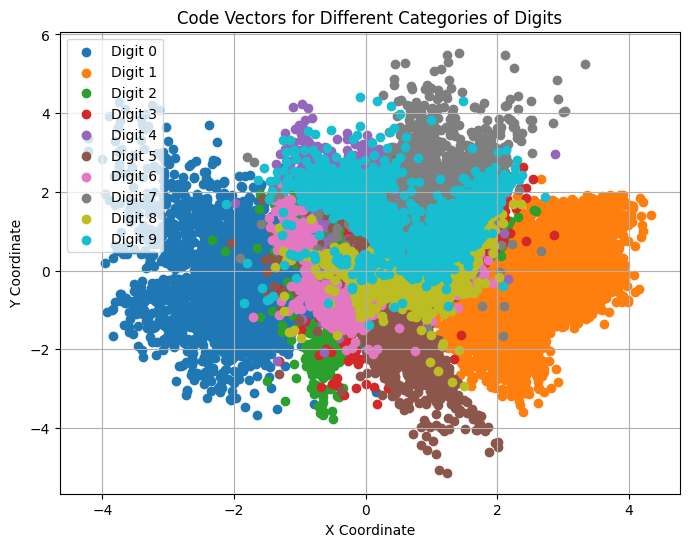

In [34]:
# plot code vectors in matplotlib
import matplotlib.pyplot as plt

x_coords = code_vectors[:, 0]
y_coords = code_vectors[:, 1]
plt.figure(figsize=(8, 6))
unique_labels = set(all_labels)
colors = plt.cm.get_cmap('tab10', len(unique_labels))

for i, label in enumerate(unique_labels):
    mask = (all_labels == label)
    plt.scatter(x_coords[mask], y_coords[mask], color=colors(i), label=f'Digit {label}')

plt.title('Code Vectors for Different Categories of Digits')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.grid(True)
plt.show()

Text(0, 0.5, 'loss value')

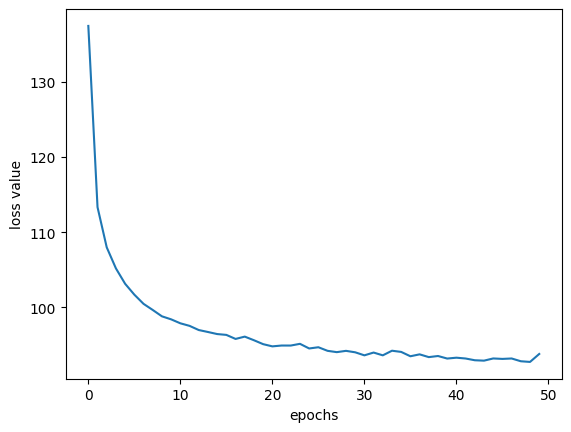

In [18]:
plt.plot(loss_list)
plt.xlabel('epochs')
plt.ylabel('loss value')

In [19]:
def generate(num_samples):
  model.eval()
  with torch.no_grad():
    z = torch.randn(num_samples, latent_size).to(device) #creates random var from std normal distr
    samples = model.decoder(z).cpu()

  return samples.view(-1, 1, 28, 28)


In [23]:
samples = generate(6)

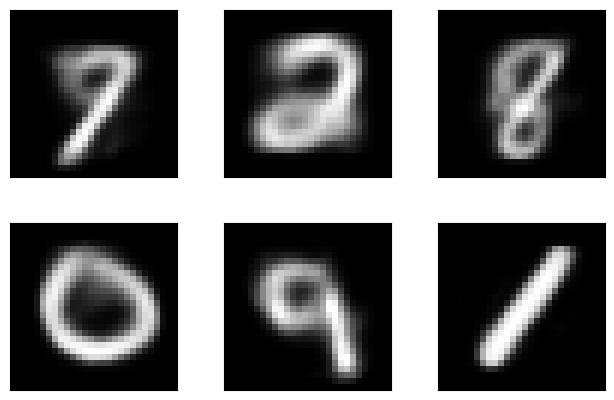

In [24]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2, 3, i+1)
  plt.tight_layout()
  plt.imshow(samples[i][0], cmap='gray', interpolation='none')
  plt.xticks([])
  plt.yticks([])

In [22]:
# 1. Set the latent size to 2
# ---- after training -----
# 2. Calculate code vectors for the whole dataset.
# 3. Interpret the 2 sized vectors as x coordinate and y coordinate,
# 4. Plot the code vectors for each category of digits in different colours.